<a href="https://colab.research.google.com/github/Pankaj1357/HC18-Grand-Challenge/blob/master/HC18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import time

# **Mask Generation**
Done only once and replaced that  annotation with masks permanently
Did not changed the annotation file name though

## **Warning!!!**
Do not run below cells as task is already completed

In [2]:
train_pixel_file = pd.read_csv('training_set_pixel_size_and_HC.csv')
train_pixel_file.head()
# This Dataframe will be used to extract image names hence by doing image_name + '_Annotation' we will get annotation names

,filename,pixel size(mm),head circumference (mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81


In [3]:
# This function takes annotation and spits out corresponding mask
def masking(image):
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    contours,useless = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ellipse = cv2.fitEllipse(contours[0])
    return cv2.ellipse(image, ellipse, (255,255,255), -1)

training_set/000_HC_Annotation.png
training_set/001_HC_Annotation.png
training_set/002_HC_Annotation.png
training_set/003_HC_Annotation.png
training_set/004_HC_Annotation.png
training_set/005_HC_Annotation.png
training_set/006_HC_Annotation.png


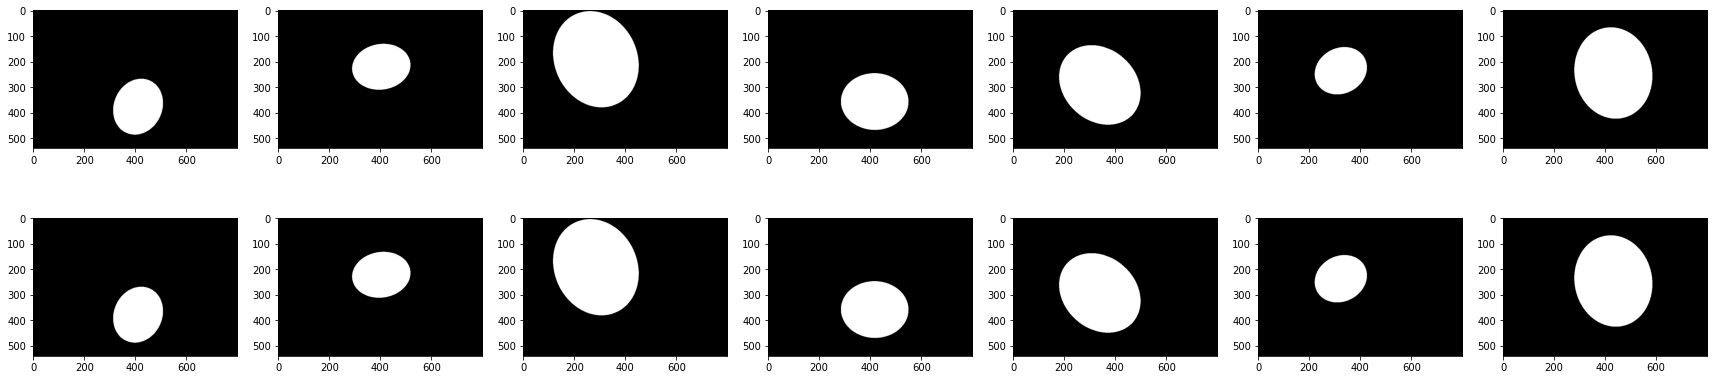

In [4]:
# to check if our masking function is working correctly
fig = plt.figure(figsize = (30,7))
for index in range(7):
  file_path = os.path.join('training_set', train_pixel_file.iloc[index, 0].replace('.png','_Annotation.png'))
  print(file_path)
  ax = fig.add_subplot(2, 7, index+1)             ## annoted plot
  plt.imshow(cv2.imread(file_path))
    
  ax = fig.add_subplot(2, 7, index+8)
  plt.imshow(masking(cv2.imread(file_path)))        ## mask plot

In [5]:
# Here we loop through training set and  take annotations one by one and replace them with corresponding masks
fig = plt.figure(figsize = (30,7))
for index in range(len(train_pixel_file)):
    file_path = os.path.join('training_set', train_pixel_file.iloc[index, 0].replace('.png','_Annotation.png'))
    image = cv2.imread(file_path)
    mask = masking(image)
    cv2.imwrite(file_path, mask)

<Figure size 2160x504 with 0 Axes>

## **Warning!!!**
**Done with mask generation. Don't run above cells ever again**

### **Do all the imports in below cell**

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from skimage import io, color
from PIL import Image
import cv2

import os
import random

import torch
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [7]:
validation_set_size = 0.20            # fraction of dataset used for validation which will be splited randomly

In [8]:
# our dataset class
class HC18(Dataset):
  #""" train and validation dataset class"""
    def __init__(self, root_dir, train = True, transformX = None, transformY = None):
        self.pixel_file = pd.read_csv(os.path.join(root_dir, 'training_set_pixel_size_and_HC.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        self.transformY = transformY
        self.train = train
        
        # lets split the dataset in train and validation
        self.train_data, self.validation_data = train_test_split(self.pixel_file, test_size = validation_set_size, random_state = 5)
        
    def __len__(self):
        
        if self.train:
          length = len(self.train_data)
        else:
          length = len(self.validation_data)
        return length
    
    def __getitem__(self, index):
      
        if self.train:
          imx_name = os.path.join(self.root_dir, 'training_set', self.train_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'training_set',self.train_data.iloc[index, 0].replace('.png','_Annotation.png'))

        else:
          imx_name = os.path.join(self.root_dir, 'training_set', self.validation_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'training_set',self.validation_data.iloc[index, 0].replace('.png','_Annotation.png'))
        
        
        imx = Image.open(imx_name)
        imy = Image.open(imy_name).convert('L')
        
        ## tried some data augmentation techniques
#         if self.train:
#           # Random horizontal flipping
#           if random.random() > 0.5:
#               imx = TF.hflip(imx)
#               imy = TF.hflip(imy)

#           # Random vertical flipping
#           if random.random() > 0.5:
#               imx = TF.vflip(imx)
#               imy = TF.vflip(imy)


#           # Random rotation
#           if random.random() > 0.8:
#             angle = random.choice([-30, -90, -60, -45 -15, 0, 15, 30, 45, 60, 90])
#             imx = TF.rotate(imx, angle)
#             imy = TF.rotate(imy, angle)
        
        
        
        
        
        
        if self.transformX :
            imx = self.transformX(imx)
            imy = self.transformY(imy)
        
        sample = {'image': imx, 'annotation': imy}
        return sample

In [9]:
# our datasets
tx_X = transforms.Compose([ transforms.Resize((572, 572)),
                            transforms.RandAugment(),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                              ])
tx_Y = transforms.Compose([ transforms.Resize((572, 572)),
                              transforms.ToTensor(),  ################ no need to normalize the maskk
                             # transforms.Normalize((0.5,), (0.5,))
                              ])
train_data = HC18('', train = True, transformX = tx_X, transformY = tx_Y)
validation_data = HC18('', train = False, transformX = tx_X, transformY = tx_Y )

In [10]:
# our dataloaders
train_loader = DataLoader(dataset = train_data, batch_size = 2, shuffle = True, num_workers = 2 )
validation_loader = DataLoader(dataset = validation_data, batch_size = 2, shuffle = True, num_workers = 2)

In [11]:
# this function will return numpy array from the transformed tensors which were
# obtained from our train_loader. Just to plot them and see if they are intact :) ha ha
def im_converterX(tensor):
    image = tensor.cpu().clone().detach().numpy() # make copy of tensor and converting it to numpy as we will need original later
    image = image.transpose(1,2,0) # swapping axes making (1, 28, 28) image to a (28, 28, 1)
 # print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # unnormalizing the image # this also outputs (28, 28, 3) which seems important for plt.imshow
    image = image.clip(0, 1) # to make sure final values are in range 0 to 1 as .ToTensor outputed
    return image

In [12]:
# this function will return numpy array from the transformed tensors which were
# obtained from our train_loader. Just to plot them and see if they are intact :) ha ha
def im_converterY(tensor):
    image = tensor.cpu().clone().detach().numpy() # make copy of tensor and converting it to numpy as we will need original later
    image = image.transpose(1,2,0) # swapping axes making (1, 28, 28) image to a (28, 28, 1)
 # print(image.shape)
    image = image * np.array((1, 1, 1)) # unnormalizing the image  not needed# this also outputs (28, 28, 3) which seems important for plt.imshow
    image = image.clip(0, 1) # to make sure final values are in range 0 to 1 as .ToTensor outputed
    return image

0 torch.Size([2, 1, 572, 572]) torch.Size([2, 1, 572, 572])


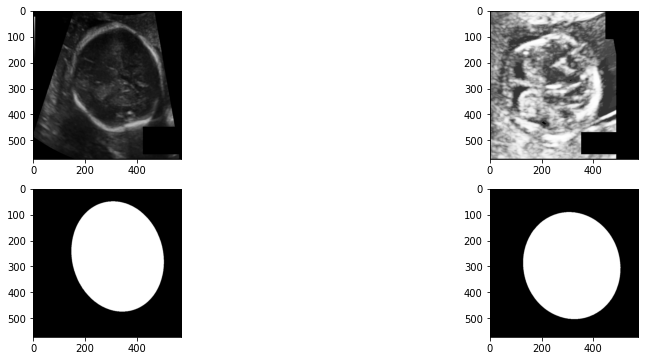

In [13]:
## Here we loop through our train_loader and see the images
## Looks good
fig = plt.figure(figsize = (15,6))
for ith_batch, sample_batched in enumerate(train_loader):
    print(ith_batch, sample_batched['image'].size(), sample_batched['annotation'].size())
    
    for index in range(2):
        ax = fig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
        plt.imshow(im_converterX(sample_batched['image'][index]))
        ax = fig.add_subplot(2, 2, index + 3)
        plt.imshow(im_converterY(sample_batched['annotation'][index]))
    break

In [14]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            #nn.Dropout2d(0.7),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            #nn.Dropout2d(0.77),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear: #upsampling will not be learnable
            self.up = nn.Upsample(
                scale_factor=2, mode='bilinear', align_corners=True)
        else:  # it will be learnable here
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)
        
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [15]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, bilinear = False) # upsampling weights are made learnable
        self.up2 = up(512, 128, bilinear = False)
        self.up3 = up(256, 64, bilinear = False)
        self.up4 = up(128, 64, bilinear = False)
        self.outc = outconv(64, n_classes)
        self.dropout = torch.nn.Dropout2d(0.5)

    def forward(self, x):
        x = x.float()
        x1 = self.inc(x)
        x2 = self.down1(x1)
       # x2 = self.dropout(x2)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
       
        x = self.up1(x5, x4)
#         print(x.shape)
        x = self.up2(x, x3)
#         print(x.shape)
        x = self.dropout(x)
        x = self.up3(x, x2)
#         print(x.shape)
        #x = self.dropout(x) #
        x = self.up4(x, x1)
#         print(x.shape)
        x = self.outc(x)
#         print(x.shape)
        return torch.sigmoid(x)
      
      
      
      
      
      
model = UNet(1, 1)
model.to('cuda')
print("Model Loaded to GPU")

Model Loaded to GPU


In [16]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0154)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [17]:
# calculates similarity index between predicted and actual segmentation
def dice_index(y_pred, y_actual):
    smooth = 0.000001
    size_of_batch = y_pred.size(0)
    
    p1 = y_pred.view(size_of_batch, -1)
    p2 = y_actual.view(size_of_batch, -1)
    
    intersection = (p1 * p2).sum()
    
    dice =  ((2.0 * intersection )+ smooth) / (p1.sum() + p2.sum() + smooth)
    #dice.requires_grad = True
    
    return dice

In [18]:
# calculate dice loss which will be later used in loss function calculation
def dice_loss(y_predict, y_train): ## to add in bce looss
  
  dice_loss = 1 -(dice_index(y_predict, y_train))
  
  return dice_loss
  

In [19]:
epochs = 150


train_running_loss_history = []
validation_running_loss_history =[]
start_time_training = time.time()
for e in range(epochs):
  train_running_loss = 0.0
  validation_running_loss = 0.0
  
  model.train()
  
  for ith_batch, sample_batched in enumerate(train_loader):
    X_train = sample_batched['image'].to('cuda')
    y_train = sample_batched['annotation'].to('cuda')
    
    #X_train.requires_grad = True
    #y_train.requires_grad = True

    #print(ith_batch) #, X_train.size(), y_train.size())

    optimizer.zero_grad()
    y_pred = model(X_train)
   # out = (y_pred + 0.5).int().float()
    
    loss = 0.30 * dice_loss(y_pred, y_train) +  0.70 * criterion(y_pred, y_train)
    #loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    if ith_batch % 50 == 0:
      print('Epoch: ', e + 1, 'Batch: ', ith_batch, 'Current Loss: ', loss.item())
      
    train_running_loss += loss.item()
    
    
    
    
  else:
    print('else')
    with torch.no_grad():
      
      model.eval()
      
      for ith_batch, sample_batched in enumerate(validation_loader):
          X_val = sample_batched['image'].to('cuda')
          y_val = sample_batched['annotation'].to('cuda')
          
          
          
          y_out = model(X_val)
          out_val = (y_out + 0.5).int().float()
          
          val_loss = 0.3 * dice_loss(out_val, y_val)  + 0.7 * criterion(y_out, y_val)
          
          #val_loss = criterion(y_out, y_val)
          
          validation_running_loss += val_loss.item()
      print("================================================================================")
      print("Epoch {} completed".format(e + 1))
      
      train_epoch_loss = train_running_loss / len(train_loader)
      validation_epoch_loss = validation_running_loss / len(validation_loader)
      
      print("Average train loss is {}: ".format(train_epoch_loss))
      print("Average validation loss is {}".format(validation_epoch_loss))
      train_running_loss_history.append(train_epoch_loss)
      validation_running_loss_history.append(validation_epoch_loss)
      print("total running time is %s minutes" % ((time.time() - start_time_training)/60))                                       
      print("================================================================================") 
      #print(y_pred.shape)

    #y_pred = y_pred.to('cpu')
    #X_train = X_train.to('cpu')

    #del y_train
    #torch.cuda.empty_cache()
    #if ith_batch ==100:
    #break
  #for index in range(2):
  #         ax = gig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
   #         plt.imshow(im_converter(X_train[index]))
    #        ax = gig.add_subplot(2, 2, index + 3)
     #       plt.imshow(im_converter(y_pred[index]))
  
    
  
   
  

  
  
  
    

Epoch:  1 Batch:  0 Current Loss:  0.6856710910797119
Epoch:  1 Batch:  50 Current Loss:  0.5047874450683594
Epoch:  1 Batch:  100 Current Loss:  0.4650270342826843
Epoch:  1 Batch:  150 Current Loss:  0.7044275999069214
Epoch:  1 Batch:  200 Current Loss:  0.33332452178001404
Epoch:  1 Batch:  250 Current Loss:  0.3631019592285156
Epoch:  1 Batch:  300 Current Loss:  0.3481687307357788
Epoch:  1 Batch:  350 Current Loss:  0.31788045167922974
else
Epoch 1 completed
Average train loss is 0.43534338030964137: 
Average validation loss is 0.5682687458395957
total running time is 6.370794693628947 minutes
Epoch:  2 Batch:  0 Current Loss:  0.3122381865978241
Epoch:  2 Batch:  50 Current Loss:  0.4555025100708008
Epoch:  2 Batch:  100 Current Loss:  0.5126144886016846
Epoch:  2 Batch:  150 Current Loss:  0.45344725251197815
Epoch:  2 Batch:  200 Current Loss:  0.3204498291015625
Epoch:  2 Batch:  250 Current Loss:  0.4189891219139099
Epoch:  2 Batch:  300 Current Loss:  0.20508812367916107
E

Epoch:  12 Batch:  0 Current Loss:  0.2395089566707611
Epoch:  12 Batch:  50 Current Loss:  0.13885459303855896
Epoch:  12 Batch:  100 Current Loss:  0.2623532712459564
Epoch:  12 Batch:  150 Current Loss:  0.2852390706539154
Epoch:  12 Batch:  200 Current Loss:  0.23041309416294098
Epoch:  12 Batch:  250 Current Loss:  0.341416597366333
Epoch:  12 Batch:  300 Current Loss:  0.23036223649978638
Epoch:  12 Batch:  350 Current Loss:  0.11277483403682709
else
Epoch 12 completed
Average train loss is 0.20622968974523245: 
Average validation loss is 0.2076212256029248
total running time is 46.05626053412755 minutes
Epoch:  13 Batch:  0 Current Loss:  0.20205728709697723
Epoch:  13 Batch:  50 Current Loss:  0.21570724248886108
Epoch:  13 Batch:  100 Current Loss:  0.29501017928123474
Epoch:  13 Batch:  150 Current Loss:  0.2172529399394989
Epoch:  13 Batch:  200 Current Loss:  0.2573572099208832
Epoch:  13 Batch:  250 Current Loss:  0.14148810505867004
Epoch:  13 Batch:  300 Current Loss:  0

Epoch:  22 Batch:  350 Current Loss:  0.2408066689968109
else
Epoch 22 completed
Average train loss is 0.15978543343022467: 
Average validation loss is 0.32899743668735026
total running time is 80.64769192536671 minutes
Epoch:  23 Batch:  0 Current Loss:  0.13702130317687988
Epoch:  23 Batch:  50 Current Loss:  0.12034135311841965
Epoch:  23 Batch:  100 Current Loss:  0.25230103731155396
Epoch:  23 Batch:  150 Current Loss:  0.09868597984313965
Epoch:  23 Batch:  200 Current Loss:  0.07716862857341766
Epoch:  23 Batch:  250 Current Loss:  0.12119126319885254
Epoch:  23 Batch:  300 Current Loss:  0.20107972621917725
Epoch:  23 Batch:  350 Current Loss:  0.09417460858821869
else
Epoch 23 completed
Average train loss is 0.15573578367009758: 
Average validation loss is 0.22402321074157952
total running time is 83.4859630982081 minutes
Epoch:  24 Batch:  0 Current Loss:  0.2138471007347107
Epoch:  24 Batch:  50 Current Loss:  0.14149229228496552
Epoch:  24 Batch:  100 Current Loss:  0.23714

Epoch:  33 Batch:  0 Current Loss:  0.05798467993736267
Epoch:  33 Batch:  50 Current Loss:  0.04212213307619095
Epoch:  33 Batch:  100 Current Loss:  0.2320191115140915
Epoch:  33 Batch:  150 Current Loss:  0.05565601587295532
Epoch:  33 Batch:  200 Current Loss:  0.04496354982256889
Epoch:  33 Batch:  250 Current Loss:  0.0785059928894043
Epoch:  33 Batch:  300 Current Loss:  0.06255150586366653
Epoch:  33 Batch:  350 Current Loss:  0.15085381269454956
else
Epoch 33 completed
Average train loss is 0.1286720406729728: 
Average validation loss is 0.22130037374794484
total running time is 116.23682535886765 minutes
Epoch:  34 Batch:  0 Current Loss:  0.18281200528144836
Epoch:  34 Batch:  50 Current Loss:  0.050898920744657516
Epoch:  34 Batch:  100 Current Loss:  0.09147302806377411
Epoch:  34 Batch:  150 Current Loss:  0.04845453053712845
Epoch:  34 Batch:  200 Current Loss:  0.0390595942735672
Epoch:  34 Batch:  250 Current Loss:  0.05923422425985336
Epoch:  34 Batch:  300 Current Lo

Epoch:  43 Batch:  350 Current Loss:  0.23420244455337524
else
Epoch 43 completed
Average train loss is 0.11100594574585557: 
Average validation loss is 0.1825961484760046
total running time is 148.6660293062528 minutes
Epoch:  44 Batch:  0 Current Loss:  0.08954987674951553
Epoch:  44 Batch:  50 Current Loss:  0.2051919400691986
Epoch:  44 Batch:  100 Current Loss:  0.0799834132194519
Epoch:  44 Batch:  150 Current Loss:  0.03916708752512932
Epoch:  44 Batch:  200 Current Loss:  0.052021391689777374
Epoch:  44 Batch:  250 Current Loss:  0.044735465198755264
Epoch:  44 Batch:  300 Current Loss:  0.041367754340171814
Epoch:  44 Batch:  350 Current Loss:  0.1376817524433136
else
Epoch 44 completed
Average train loss is 0.10911776080261916: 
Average validation loss is 0.2100957491248846
total running time is 151.44244074424108 minutes
Epoch:  45 Batch:  0 Current Loss:  0.2148253172636032
Epoch:  45 Batch:  50 Current Loss:  0.29811322689056396
Epoch:  45 Batch:  100 Current Loss:  0.0918

Epoch:  54 Batch:  0 Current Loss:  0.1470746397972107
Epoch:  54 Batch:  50 Current Loss:  0.03731944411993027
Epoch:  54 Batch:  100 Current Loss:  0.1557198166847229
Epoch:  54 Batch:  150 Current Loss:  0.29442477226257324
Epoch:  54 Batch:  200 Current Loss:  0.1252094954252243
Epoch:  54 Batch:  250 Current Loss:  0.09844127297401428
Epoch:  54 Batch:  300 Current Loss:  0.04953275993466377
Epoch:  54 Batch:  350 Current Loss:  0.3111908435821533
else
Epoch 54 completed
Average train loss is 0.0996223191311583: 
Average validation loss is 0.20206266440451146
total running time is 182.22550001541774 minutes
Epoch:  55 Batch:  0 Current Loss:  0.1337016224861145
Epoch:  55 Batch:  50 Current Loss:  0.12461656332015991
Epoch:  55 Batch:  100 Current Loss:  0.07885865867137909
Epoch:  55 Batch:  150 Current Loss:  0.1574312001466751
Epoch:  55 Batch:  200 Current Loss:  0.18238122761249542
Epoch:  55 Batch:  250 Current Loss:  0.03466802090406418
Epoch:  55 Batch:  300 Current Loss: 

Epoch:  64 Batch:  300 Current Loss:  0.08000720292329788
Epoch:  64 Batch:  350 Current Loss:  0.08984824270009995
else
Epoch 64 completed
Average train loss is 0.1048258206807077: 
Average validation loss is 0.2040569644421339
total running time is 212.90367793242137 minutes
Epoch:  65 Batch:  0 Current Loss:  0.07321882992982864
Epoch:  65 Batch:  50 Current Loss:  0.11409087479114532
Epoch:  65 Batch:  100 Current Loss:  0.14304208755493164
Epoch:  65 Batch:  150 Current Loss:  0.024712732061743736
Epoch:  65 Batch:  200 Current Loss:  0.0733172595500946
Epoch:  65 Batch:  250 Current Loss:  0.15776124596595764
Epoch:  65 Batch:  300 Current Loss:  0.10990536212921143
Epoch:  65 Batch:  350 Current Loss:  0.1398223340511322
else
Epoch 65 completed
Average train loss is 0.09654242576565593: 
Average validation loss is 0.17026271980255842
total running time is 215.65342026551565 minutes
Epoch:  66 Batch:  0 Current Loss:  0.16144973039627075
Epoch:  66 Batch:  50 Current Loss:  0.102

Epoch:  75 Batch:  0 Current Loss:  0.03827659413218498
Epoch:  75 Batch:  50 Current Loss:  0.10366670787334442
Epoch:  75 Batch:  100 Current Loss:  0.15718573331832886
Epoch:  75 Batch:  150 Current Loss:  0.034422941505908966
Epoch:  75 Batch:  200 Current Loss:  0.04802646487951279
Epoch:  75 Batch:  250 Current Loss:  0.029871225357055664
Epoch:  75 Batch:  300 Current Loss:  0.11917765438556671
Epoch:  75 Batch:  350 Current Loss:  0.024472318589687347
else
Epoch 75 completed
Average train loss is 0.08545486964751035: 
Average validation loss is 0.19108335776254534
total running time is 246.2487135330836 minutes
Epoch:  76 Batch:  0 Current Loss:  0.10396362096071243
Epoch:  76 Batch:  50 Current Loss:  0.05642439424991608
Epoch:  76 Batch:  100 Current Loss:  0.23480358719825745
Epoch:  76 Batch:  150 Current Loss:  0.02701546810567379
Epoch:  76 Batch:  200 Current Loss:  0.1579570174217224
Epoch:  76 Batch:  250 Current Loss:  0.08484703302383423
Epoch:  76 Batch:  300 Curren

Epoch:  85 Batch:  300 Current Loss:  0.04595165699720383
Epoch:  85 Batch:  350 Current Loss:  0.08265107125043869
else
Epoch 85 completed
Average train loss is 0.08313740420155227: 
Average validation loss is 0.17671293573454022
total running time is 276.781176785628 minutes
Epoch:  86 Batch:  0 Current Loss:  0.06034329906105995
Epoch:  86 Batch:  50 Current Loss:  0.05048225075006485
Epoch:  86 Batch:  100 Current Loss:  0.043033666908741
Epoch:  86 Batch:  150 Current Loss:  0.040215544402599335
Epoch:  86 Batch:  200 Current Loss:  0.20038557052612305
Epoch:  86 Batch:  250 Current Loss:  0.1574370563030243
Epoch:  86 Batch:  300 Current Loss:  0.027144379913806915
Epoch:  86 Batch:  350 Current Loss:  0.04398667439818382
else
Epoch 86 completed
Average train loss is 0.09464877395424992: 
Average validation loss is 0.17186079680919647
total running time is 279.5145518898964 minutes
Epoch:  87 Batch:  0 Current Loss:  0.16312716901302338
Epoch:  87 Batch:  50 Current Loss:  0.0452

Epoch:  96 Batch:  0 Current Loss:  0.14111152291297913
Epoch:  96 Batch:  50 Current Loss:  0.17930537462234497
Epoch:  96 Batch:  100 Current Loss:  0.06299705058336258
Epoch:  96 Batch:  150 Current Loss:  0.050475142896175385
Epoch:  96 Batch:  200 Current Loss:  0.1173715740442276
Epoch:  96 Batch:  250 Current Loss:  0.02800983563065529
Epoch:  96 Batch:  300 Current Loss:  0.046000123023986816
Epoch:  96 Batch:  350 Current Loss:  0.10327871143817902
else
Epoch 96 completed
Average train loss is 0.0881740905623883: 
Average validation loss is 0.17932587657123805
total running time is 308.67113298972447 minutes
Epoch:  97 Batch:  0 Current Loss:  0.039875321090221405
Epoch:  97 Batch:  50 Current Loss:  0.13745951652526855
Epoch:  97 Batch:  100 Current Loss:  0.0740407183766365
Epoch:  97 Batch:  150 Current Loss:  0.05688253045082092
Epoch:  97 Batch:  200 Current Loss:  0.1063760444521904
Epoch:  97 Batch:  250 Current Loss:  0.10026156157255173
Epoch:  97 Batch:  300 Current 

Epoch:  106 Batch:  250 Current Loss:  0.035994794219732285
Epoch:  106 Batch:  300 Current Loss:  0.08197575062513351
Epoch:  106 Batch:  350 Current Loss:  0.12654797732830048
else
Epoch 106 completed
Average train loss is 0.08904404340311885: 
Average validation loss is 0.1822376736626029
total running time is 337.2728514234225 minutes
Epoch:  107 Batch:  0 Current Loss:  0.08692703396081924
Epoch:  107 Batch:  50 Current Loss:  0.08524243533611298
Epoch:  107 Batch:  100 Current Loss:  0.17384523153305054
Epoch:  107 Batch:  150 Current Loss:  0.13784845173358917
Epoch:  107 Batch:  200 Current Loss:  0.02892494387924671
Epoch:  107 Batch:  250 Current Loss:  0.09829128533601761
Epoch:  107 Batch:  300 Current Loss:  0.02760346792638302
Epoch:  107 Batch:  350 Current Loss:  0.034558214247226715
else
Epoch 107 completed
Average train loss is 0.08475584008265287: 
Average validation loss is 0.21596890576183797
total running time is 339.9955023606618 minutes
Epoch:  108 Batch:  0 Cur

Epoch:  117 Batch:  0 Current Loss:  0.03710299730300903
Epoch:  117 Batch:  50 Current Loss:  0.039335623383522034
Epoch:  117 Batch:  100 Current Loss:  0.032203309237957
Epoch:  117 Batch:  150 Current Loss:  0.05354868620634079
Epoch:  117 Batch:  200 Current Loss:  0.052415311336517334
Epoch:  117 Batch:  250 Current Loss:  0.037564966827631
Epoch:  117 Batch:  300 Current Loss:  0.03436234965920448
Epoch:  117 Batch:  350 Current Loss:  0.0715237632393837
else
Epoch 117 completed
Average train loss is 0.08629890244919806: 
Average validation loss is 0.1736596705764532
total running time is 370.3952327609062 minutes
Epoch:  118 Batch:  0 Current Loss:  0.037588588893413544
Epoch:  118 Batch:  50 Current Loss:  0.036662425845861435
Epoch:  118 Batch:  100 Current Loss:  0.043396707624197006
Epoch:  118 Batch:  150 Current Loss:  0.08854493498802185
Epoch:  118 Batch:  200 Current Loss:  0.04015372693538666
Epoch:  118 Batch:  250 Current Loss:  0.03780963644385338
Epoch:  118 Batch

Epoch:  127 Batch:  250 Current Loss:  0.0849115252494812
Epoch:  127 Batch:  300 Current Loss:  0.023518750444054604
Epoch:  127 Batch:  350 Current Loss:  0.046551432460546494
else
Epoch 127 completed
Average train loss is 0.08334947729948908: 
Average validation loss is 0.20435346499085427
total running time is 400.77751829624174 minutes
Epoch:  128 Batch:  0 Current Loss:  0.048627354204654694
Epoch:  128 Batch:  50 Current Loss:  0.10924820601940155
Epoch:  128 Batch:  100 Current Loss:  0.027514446526765823
Epoch:  128 Batch:  150 Current Loss:  0.06354361027479172
Epoch:  128 Batch:  200 Current Loss:  0.04187317565083504
Epoch:  128 Batch:  250 Current Loss:  0.11627045273780823
Epoch:  128 Batch:  300 Current Loss:  0.0378691628575325
Epoch:  128 Batch:  350 Current Loss:  0.021475590765476227
else
Epoch 128 completed
Average train loss is 0.0766570804733783: 
Average validation loss is 0.192307370826602
total running time is 403.49579530159633 minutes
Epoch:  129 Batch:  0 Cu

Epoch:  138 Batch:  0 Current Loss:  0.02922884188592434
Epoch:  138 Batch:  50 Current Loss:  0.13163165748119354
Epoch:  138 Batch:  100 Current Loss:  0.07659700512886047
Epoch:  138 Batch:  150 Current Loss:  0.09675362706184387
Epoch:  138 Batch:  200 Current Loss:  0.07596438378095627
Epoch:  138 Batch:  250 Current Loss:  0.08702696114778519
Epoch:  138 Batch:  300 Current Loss:  0.17669638991355896
Epoch:  138 Batch:  350 Current Loss:  0.2001793086528778
else
Epoch 138 completed
Average train loss is 0.08422848739195615: 
Average validation loss is 0.17235634543001652
total running time is 430.65473815600075 minutes
Epoch:  139 Batch:  0 Current Loss:  0.0363798588514328
Epoch:  139 Batch:  50 Current Loss:  0.15467509627342224
Epoch:  139 Batch:  100 Current Loss:  0.09711001813411713
Epoch:  139 Batch:  150 Current Loss:  0.038818053901195526
Epoch:  139 Batch:  200 Current Loss:  0.0986831784248352
Epoch:  139 Batch:  250 Current Loss:  0.04055725783109665
Epoch:  139 Batch

Epoch:  148 Batch:  250 Current Loss:  0.045762624591588974
Epoch:  148 Batch:  300 Current Loss:  0.038630153983831406
Epoch:  148 Batch:  350 Current Loss:  0.09220381826162338
else
Epoch 148 completed
Average train loss is 0.07894454920198768: 
Average validation loss is 0.2178960705921054
total running time is 460.9977353374163 minutes
Epoch:  149 Batch:  0 Current Loss:  0.09836225211620331
Epoch:  149 Batch:  50 Current Loss:  0.03603152185678482
Epoch:  149 Batch:  100 Current Loss:  0.02574593760073185
Epoch:  149 Batch:  150 Current Loss:  0.03931647539138794
Epoch:  149 Batch:  200 Current Loss:  0.0590934082865715
Epoch:  149 Batch:  250 Current Loss:  0.11839325726032257
Epoch:  149 Batch:  300 Current Loss:  0.04475710541009903
Epoch:  149 Batch:  350 Current Loss:  0.10317578911781311
else
Epoch 149 completed
Average train loss is 0.07285953978076577: 
Average validation loss is 0.1686298057436943
total running time is 463.7078638037046 minutes
Epoch:  150 Batch:  0 Curre

In [20]:
torch.save(model,"Models/Unet_Cos_RandAug_150.pt")    

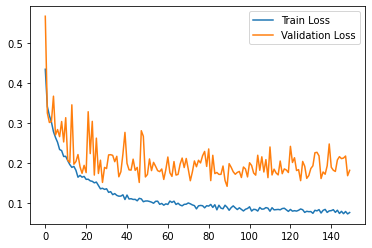

In [21]:
plt.plot(train_running_loss_history, label = 'Train Loss')
plt.plot(validation_running_loss_history, label = 'Validation Loss')
plt.legend()

In [ ]:
model.eval()
X_train.size()

In [ ]:
out = (y_pred + 0.5).int().float()

In [ ]:
print(dice_index(y_train, out))
print(dice_loss(y_train, out))

In [ ]:
# pig = plt.figure(figsize = (15, 6))

# a = pig.add_subplot(2, 3, 1)
# plt.imshow(im_converterX(X_train[0]))

# a = pig.add_subplot(2, 3, 2)
# plt.imshow(im_converterY(y_train[0]))

# a = pig.add_subplot(2, 3, 3)
# plt.imshow(im_converterY(out[0]))


# a = pig.add_subplot(2, 3, 4)
# plt.imshow(im_converterX(X_train[1]))

# a = pig.add_subplot(2, 3, 5)
# plt.imshow(im_converterY(y_train[1]))

# a = pig.add_subplot(2, 3, 6)
# plt.imshow(im_converterY(out[1]))

In [ ]:
gg = dice_index(out, y_train)
print(gg)
print(dice_loss(out, y_train))

In [ ]:
class HC18_test(Dataset):
    def __init__(self, root_dir, transformX = None):
        self.pixel_file = pd.read_csv(os.path.join(root_dir, 'test_set_pixel_size.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        
    def __len__(self):
        return len(self.pixel_file)
    
    def __getitem__(self, index):
        imx_name = os.path.join(self.root_dir, 'test_set', self.pixel_file.iloc[index, 0])
        
        imx = Image.open(imx_name)
        
        f_name = self.pixel_file.iloc[index, 0]
        
        if self.transformX :
            imx = self.transformX(imx)
        
        sample = {'image': imx, 'f_name': f_name}
        return sample

In [ ]:
test_data = HC18_test('', transformX = tx_X)

In [ ]:
test_data

In [ ]:
test_loader = DataLoader(dataset = test_data, batch_size = 2, shuffle = True)

In [ ]:
test_loader

In [ ]:
## Here we loop through our train_loader and see the images
## Looks good
fig = plt.figure(figsize = (15,6))
#model.to('cpu')
for ith_batch, sample_batched in enumerate(test_loader):
  
    X_test = sample_batched['image'].to('cuda')
    print(ith_batch, X_test.size())
    
    y_test = (model(X_test) + 0.5).int().float()
    
    
    
    for index in range(2):
        ax = fig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
        plt.imshow(im_converterX(X_test[index]))
        
        ax  = fig.add_subplot(2, 2, index + 3)
        plt.imshow(im_converterY(y_test[index]))
    break

In [ ]:
def avg_dice_index(dataloader):
  
    dice = 0.0
    model.eval()
    with torch.no_grad():
    
        for ith_batch, sample_batched in enumerate(dataloader):
  
            X_train = sample_batched['image'].to('cuda')
            y_train = sample_batched['annotation'].to('cuda')
            
            y_predict = (model(X_train) + 0.5).int().float()
            
            dice += dice_index(y_predict, y_train)
            
            
            
    avg_dice = dice / len(dataloader)
    return avg_dice.item()

In [ ]:
avg_dice_index(validation_loader)    #### Dice index of validation data

In [ ]:
avg_dice_index(train_loader)        ### Dice index of training data

In [ ]:
test_loader = DataLoader(dataset = test_data, batch_size = 1, shuffle = True) # to write image files

## **Warning!!!**
### Your are about to write on drive

In [ ]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((540, 800)),
        transforms.ToTensor()
        ])
    
with torch.no_grad():
      #model.eval()
      for ith_batch , sample in enumerate(test_loader):
        X_test = sample['image'].to('cuda')
        y_pred = (model(X_test) + 0.5).int().float().cpu()
#         print(335-ith_batch)
        
        file_names = sample['f_name']
        pankaj = transform(y_pred[0])
        #singh = transform(y_pred[1])
        torchvision.utils.save_image(pankaj , os.path.join('segmented', file_names[0]))
        #torchvision.utils.save_image(singh, os.path.join('/content/drive/My Drive/HC18/test_set', file_names[1].replace('.png','_Annotation.png')))
      print("Segmentation files written")
        
        

In [ ]:
def fit_ellipse(im):    
    imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray,127,255,0)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contour_sizes = [len(contour) for contour in contours]
    ellipse = cv2.fitEllipse(contours[np.argmax(contour_sizes)])
    return ellipse

In [ ]:
file_names = sorted([file for _,_,files in os.walk('segmented/') for file in files])

In [ ]:
df_pixel_size = pd.read_csv('test_set_pixel_size.csv')
submission = {'filename': [], 'center_x_mm': [], 'center_y_mm': [], 'semi_axes_a_mm': [],
             'semi_axes_b_mm': [], 'angle_rad': [], 'Index': []}

file_names = sorted([file for _,_,files in os.walk('segmented/') for file in files])

for i, file_name in enumerate(file_names):
    im = cv2.imread('segmented/'+file_name)
   # file_name = file_name.replace('_Segmented', '')
    ellipse = fit_ellipse(im)
    im_mask = cv2.ellipse(np.zeros_like(im),ellipse,(255,255,255),-1)
    image_name = file_name.split('.')[0] + '_Annotation_fit.png'
    #cv2.imwrite('/content/drive/My Drive/HC18/test_set/'+image_name, im_mask)
    
    pixel_size = df_pixel_size.loc[df_pixel_size['filename'] == file_name, 'pixel size(mm)'].iloc[0]
    submission['filename'].extend([file_name])
    submission['Index'].extend([int(file_name.split('_')[0])])
    center_x,  center_y = ellipse[0]
    submission['center_x_mm'].extend([pixel_size*center_x])
    submission['center_y_mm'].extend([pixel_size*center_y])
    semi_axes_b, semi_axes_a = ellipse[1]
    if semi_axes_b > semi_axes_a:
        semi_axes_b = semi_axes_b + semi_axes_a
        semi_axes_a = semi_axes_b - semi_axes_a
        semi_axes_b -= semi_axes_a
    submission['semi_axes_a_mm'].extend([semi_axes_a*pixel_size/2])
    submission['semi_axes_b_mm'].extend([semi_axes_b*pixel_size/2])
    angle = ellipse[2]
    if angle < 90:
        angle += 90
    else:
        angle -= 90
    submission['angle_rad'].extend([np.deg2rad(angle)])
    
submission = pd.DataFrame(submission)
submission = submission[['filename', 'center_x_mm', 'center_y_mm', 
                         'semi_axes_a_mm', 'semi_axes_b_mm', 'angle_rad', 'Index']]    
submission = submission.sort_values(['Index'])
submission = submission.drop('Index', axis=1)
submission.to_csv("Unet_Cos_RandAug_150.csv", index=False)
print('Required .csv file generated')

In [ ]:
q = pd.read_csv('Unet_Cos_RandAug_150.csv')  ## to check theck the generated csv

In [ ]:
print('Length of csv file: ',len(q))

In [ ]:
submission.head()